In [ ]:
# from getpass import getpass
# import os

# os.environ['GITHUB_AUTH'] = getpass('Enter your personal access token: ')
# !git clone -b Model_dev_Prayla https://$GITHUB_AUTH@github.com/SjoCno/Flood-5.git

Enter your personal access token: ··········
Cloning into 'Flood-5'...
remote: Enumerating objects: 834, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 834 (delta 82), reused 131 (delta 63), pack-reused 676
Receiving objects: 100% (834/834), 290.13 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (508/508), done.


In [ ]:
# %cd 'Flood-5/notebooks'
# %pwd

/content/Flood-5/notebooks


'/content/Flood-5/notebooks'

In [1]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
import pandas as pd
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Additional input
!pip install torch_geometric
from torch_geometric.data import Data
from tqdm import tqdm

# use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Sensitivity Analysis

For doing sensitivity analysis, we need the following things:
- training datasets and validation dataset because we calculate loss with it
- model, including the training and validation function
- hyperparameters

## Training and Testing Dataset
the datasets were already normalized and stored in dropbox, in the below cell, we download all of the used dataset.
We use the first training dataset.

In [2]:
# load the training and testing dataset
train_url = "https://www.dropbox.com/scl/fi/hindtga0jg65wmtoyhfl4/training_normalized.pkl?rlkey=z7l9980e7kbgoxbaqwvkmcefi&dl=1"

# define datasets path
datasets_folder = 'datasets/'
os.makedirs(datasets_folder, exist_ok=True)

train_path = os.path.join(datasets_folder, "train.pkl")

# retrieve training data from url
if not os.path.isfile(train_path):
    print("Downloading the pickled dataset...")
    urlretrieve(train_url, train_path)
else:
    print("Testing file exist")

with open(train_path, 'rb') as f:
    train_dataset = pickle.load(f)

Testing file exist


In [3]:
def CNNInput_gen(dataset):
  # adjust the amount of input to the CNN model (only DEM and initial condition)
  inputs = torch.stack([item['Input'] for item in dataset])

  # Select only the first two channels from each tensor in the batch
  inputs_two_channels = inputs[:, :2, :, :]

  # Create the new dataset
  CNNtrain_dataset = [{'Input': inputs_two_channels[i], 'WD': item['WD']} for i, item in enumerate(dataset)]

  return CNNtrain_dataset

CNNtrain_dataset = CNNInput_gen(train_dataset)
print(f'Number of samples in training dataset: {len(CNNtrain_dataset)}')

Number of samples in training dataset: 80


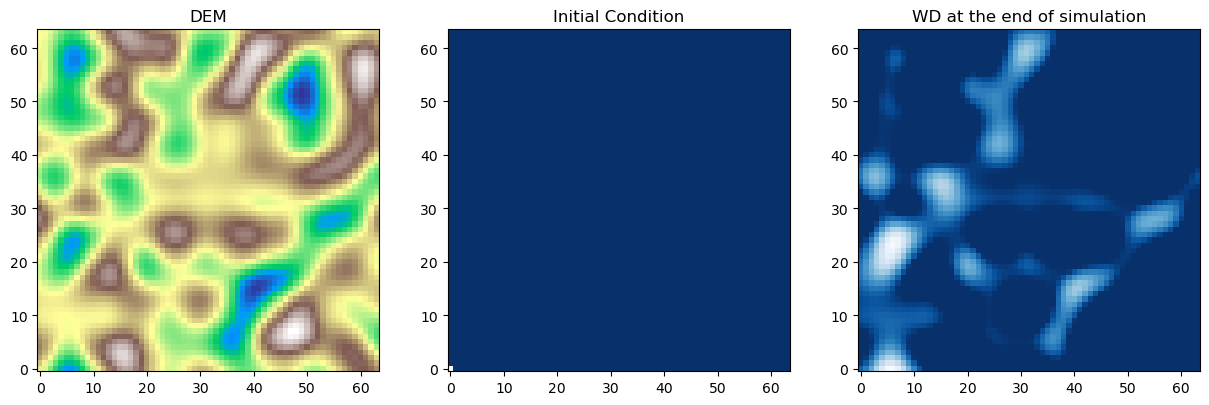

In [4]:
number_grids = 64
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(CNNtrain_dataset[0]['Input'][0].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(CNNtrain_dataset[0]['Input'][1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('Initial Condition')

axs[2].imshow(CNNtrain_dataset[0]['WD'][-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[2].set_title('WD at the end of simulation')
plt.show()

In [5]:
# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(CNNtrain_dataset))
val_size = len(CNNtrain_dataset) - train_size
training_dataset, val_dataset = random_split(CNNtrain_dataset, [train_size, val_size])

In [6]:
print(f"Sample size of training dataset is: {len(training_dataset)}")
print(f"Sample size of validation dataset is: {len(val_dataset)}")

Sample size of training dataset is: 64
Sample size of validation dataset is: 16


## Model
in the following, we load the one time prediction model with CNN

In [7]:
# get CNN model
from models.cnn import CNN

# define the model
node_features = 2
model = CNN(node_features=node_features,
            n_downsamples=4,
            initial_hid_dim=32,
            batch_norm=True,
            bias=True
           )

# load training and evaluation function
from models.trainval_cnn import train_epoch
from models.trainval_cnn import evaluation

## Hyperparameter and Sensitivity Analysis

This sensitivity analysis is done with a brute force method to find the best hyperparameters. The following hyperparameters are tweaked around the default hyperparameter settings.

- `learning_rate = 0.0002`
- `batch_size = 8`
- `num_epoch = 150`

In [8]:
# define hyperparameters variation
hyperparameters = {
    'learning_rate': [0.00005, 0.0001, 0.0002, 0.0004, 0.0008, 0.001],
    'batch_size': [1, 2, 4, 5, 8, 10, 16, 20, 40, 80],
    'num_epoch': [20, 100, 500]
}

# define the grid search algoritm for sensitivity analysis
def grid_search(model, hyperparameters, training_dataset, val_dataset):
  '''
  function to do a sensitivity analysis in grid search way
  hyperparameter is a list of hyperparameter space that one try to do sensitivity analysis
  '''
  # define array to store best model losses
  results = []
  total_iterations = len(hyperparameters['learning_rate']) * len(hyperparameters['batch_size']) * len(hyperparameters['num_epoch'])

  with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    for learning_rate in hyperparameters['learning_rate']:
      for batch_size in hyperparameters['batch_size']:
        for num_epochs in hyperparameters['num_epoch']:
          # reset parameter with re-define the model
          model_loop = copy.deepcopy(model)

          # Create the optimizer to train the neural network via back-propagation
          optimizer = torch.optim.Adam(params=model_loop.parameters(), lr=learning_rate)

          # Create the training and validation dataloaders to "feed" data to the model in batches
          train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
          val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
          #test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

          for epoch in range(1, num_epochs+1):
              # Model training
              train_loss = train_epoch(model_loop, train_loader, optimizer, device=device)

              # Model validation
              val_loss = evaluation(model_loop, val_loader, device=device)

              if epoch == 1:
                  best_loss = val_loss

              if val_loss<=best_loss:
                  best_model = copy.deepcopy(model_loop)
                  best_loss = val_loss
                  best_trainloss = train_loss
                  best_epoch = epoch
                # pepoch.update(1)
          # pepoch.close()

          results.append([learning_rate, batch_size, num_epochs, best_trainloss, best_loss])
          pbar.update(1)

    return results, best_model

In [11]:
sensitivity, best_model = grid_search(model, hyperparameters, training_dataset, val_dataset)

# Save best model
# models_folder = 'models'

# os.makedirs(models_folder, exist_ok=True)

# save_path = f'./models/model_SensitivityCNN_lr_{learning_rate}_epochs_{num_epochs}_MSELoss.pth'
# torch.save(best_model.state_dict(), save_path)

Grid Search Progress: 100%|██████████| 2/2 [00:25<00:00, 12.69s/it]


we pre-run the sensitivity analysis and stored the result on a pickle file.

In [ ]:
# # save sensitivity analysis result in pickle file
# with open('sensitivity.pkl', 'wb') as file:
#   pickle.dump(sensitivity,file)

In [14]:
# load the pickeled sensitivity
sensitivity_url = "https://www.dropbox.com/scl/fi/8p9z6bs0tyw8pppgpjmiy/sensitivity.pkl?rlkey=5ca5jdqwktptyy9447ptb4wqm&dl=1"

sensitivity_path = os.path.join("sensitivity.pkl")

if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# retrieve data from url
if not os.path.isfile(sensitivity_path):
    print("Downloading the pickled dataset...")
    urlretrieve(sensitivity_url, sensitivity_path)
else:
    print('File is exist')

with open(sensitivity_path, 'rb') as f:
    sensitivity = pickle.load(f)

In [15]:
# see the lowest loss
sensitivity_df = pd.DataFrame(sensitivity, columns=['learning_rate', 'batch_size', 'num_epochs', 'best_trainloss', 'best_loss'])
best_df = sensitivity_df.loc[(sensitivity_df['best_loss'] == min(sensitivity_df['best_loss']))]
best_df

,learning_rate,batch_size,num_epochs,best_trainloss,best_loss
165,0.0008,10,500,0.000168,0.001111


In [16]:
# vizualize the sensitivity result

def sensitivity_plot(hyperpar):
  if hyperpar == 'batch_size':
    x = 'learning_rate'
  elif hyperpar == 'learning_rate':
    x = 'batch_size'
  else:
    raise Exception("invalid hyperparameter")

  for i in range(len(hyperparameters['num_epoch'])):
    plt.subplot(3,1,i+1)
    plt.plot(hyperparameters[hyperpar],
            sensitivity_df['best_trainloss'][(sensitivity_df[x]==hyperparameters[x][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][i])],
            label='Training')
    plt.plot(hyperparameters[hyperpar],
            sensitivity_df['best_loss'][(sensitivity_df[x]==hyperparameters[x][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][i])],
            label='Validation')
    plt.title(f"Losses with num of epochs = {hyperparameters['num_epoch'][0]} and learning rate = {hyperparameters['learning_rate'][4]}")
    plt.ylim(0,0.01)
    plt.xlabel('batch size')
    plt.legend()
    plt.show()

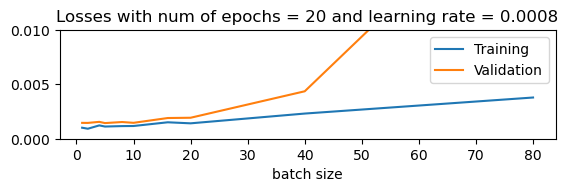

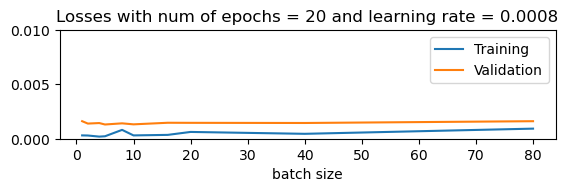

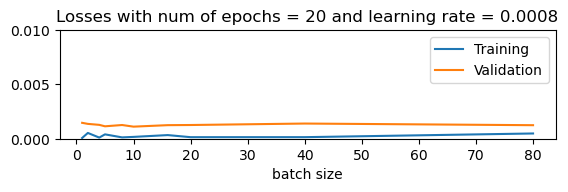

In [17]:
sensitivity_plot('batch_size')

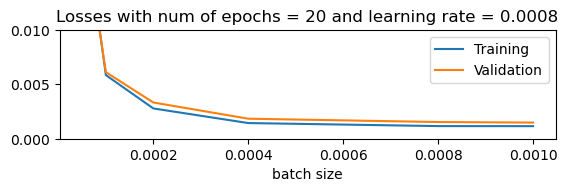

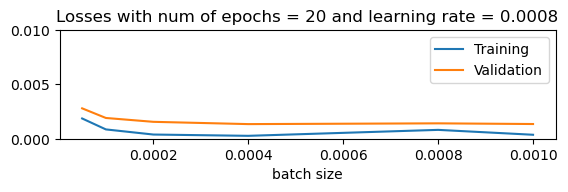

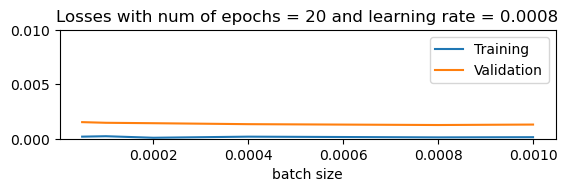

In [18]:
sensitivity_plot('learning_rate')

## Data Augmentation
we are trying to implement augmented dataset to the CNN model with the best validation loss.

In [19]:
def flip(DEM, WD0, VEL, WD, dim_DEM, dim_WD0, dim_VEL, dim_WD):
    ds_flipped = {}
    DEM_flipped = torch.flip(DEM, dims=(dim_DEM,))
    WD0_flipped = torch.flip(WD0, dims=(dim_WD0,))
    VEL_flipped = torch.flip(VEL, dims=(dim_VEL,))
    WD_flipped = torch.flip(WD, dims=(dim_WD,))

    ds_flipped['Input'] = torch.stack((DEM_flipped, WD0_flipped, VEL_flipped), dim=0)
    ds_flipped['WD'] = WD_flipped
    return ds_flipped


def augment_dataset(dataset, flips=3):
    augmented_dataset = dataset.copy()
    for idx in range(len(dataset)):
        DEM = dataset[idx]['Input'][0]
        WD0 = dataset[idx]['Input'][1]
        VEL = dataset[idx]['Input'][2]
        WD = dataset[idx]['WD']

        for i in range(flips):
            if i==flips-1:
                flip1 = flip(DEM, WD0, VEL, WD, dim_DEM=0, dim_WD0=0, dim_VEL=0, dim_WD=1)
                flip2 = flip(flip1['Input'][0], flip1['Input'][1], flip1['Input'][2], flip1['WD'], dim_DEM=1, dim_WD0=1, dim_VEL=1, dim_WD=2)
                augmented_dataset.append(flip2)
            else:
                augmented_dataset.append(flip(DEM, WD0, VEL, WD, dim_DEM=i, dim_WD0=i, dim_VEL=i, dim_WD=i+1))

    return augmented_dataset

In [20]:
aug_dataset = augment_dataset(train_dataset)
CNNaug_dataset = CNNInput_gen(aug_dataset)

# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(CNNaug_dataset))
val_size = len(CNNaug_dataset) - train_size
augtraining_dataset, augval_dataset = random_split(CNNaug_dataset, [train_size, val_size])

print(f'Number of samples on augmented dataset: {len(CNNaug_dataset)}')

Number of samples on augmented dataset: 320


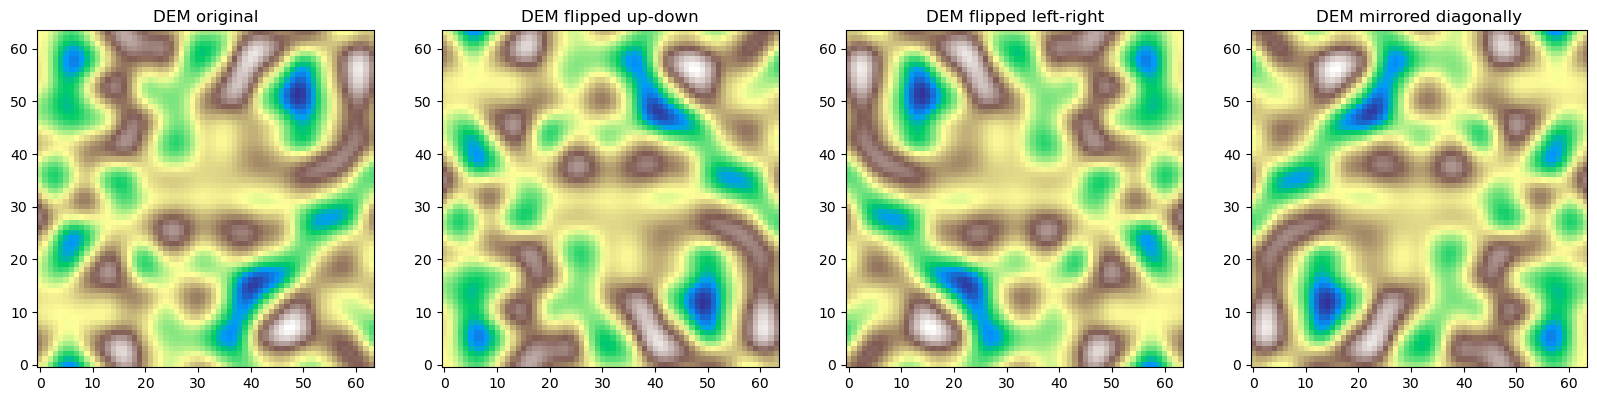

In [21]:
number_grids = 64
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(aug_dataset[0]['Input'][0].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[0].set_title('DEM original')

axs[1].imshow(aug_dataset[80]['Input'][0].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[1].set_title('DEM flipped up-down')

axs[2].imshow(aug_dataset[81]['Input'][0].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[2].set_title('DEM flipped left-right')

axs[3].imshow(aug_dataset[82]['Input'][0].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[3].set_title('DEM mirrored diagonally')
plt.show()

### Training and Validation for Augmented Data

In [22]:
# hyperparamters and dataloaders
# Set training parameters
learning_rate = best_df['learning_rate'].values[0]
batch_size = int(best_df['batch_size'].values[0])
num_epochs = 200

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(augtraining_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(augval_dataset, batch_size=batch_size, shuffle=False)

In [23]:
#create vectors for the training and validation loss
train_losses = []
val_losses = []
no_improvement = 0

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss

    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        no_improvement = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    no_improvement += 1

    if epoch%50 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4),
                            "\t best validation loss:", np.round(best_loss,4))

        # Plot prediction for one sample
        data_id = 4
        test_x = CNNaug_dataset[data_id]['Input'].reshape(1, 2, 64, 64)
        test_WD = CNNaug_dataset[data_id]['WD'][-1,:,:]

        test_x = test_x.to(device)

        # predict the WD
        pred_WD = best_model(test_x).detach()

        pred_last_WD = pred_WD[:,-1,:,:]

        show_WD = test_WD.reshape(64,64)
        show_pred_WD = pred_last_WD.reshape(64,64)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(show_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
        axs[0].set_title('WD target')

        axs[1].imshow(show_pred_WD.reshape(number_grids,number_grids).cpu(), cmap='Blues_r', origin='lower')
        axs[1].set_title('WD prediction')
        plt.show()

    if no_improvement >= 20:
        print('No improvement for 20 epochs')
        print('counter', no_improvement)


model_aug = copy.deepcopy(best_model)

KeyboardInterrupt: 

In [81]:
model_aug = copy.deepcopy(best_model)